# Using Pre-Trained Model as Feature Extractor Preprocessor
### The pre-trained model is used as a standalone program to extract features from new photographs.
# using ' Inception V3 ' model for giving features and  building feed forward networks for identifying the breed based on features.

In [1]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model,load_model
from glob import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Activation,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import os
import PIL
import time
from datetime import datetime
import json
from pathlib import Path
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
#setting up folder for the model
model_path = '/content/drive/MyDrive/DogImageClassification/models'
model_version = str(int(time.time()))
model_name = 'dog_model_v_{0}.h5'.format(model_version)
model_file_name = model_path + '/' + model_name

#setting up folder for Train data
train_folder_name = '/content/drive/MyDrive/DogImageClassification/Data/train'
validation_folder_name = '/content/drive/MyDrive/DogImageClassification/Data/test'

#output folder
output_folder_name = '/content/drive/MyDrive/DogImageClassification/Data/output'

#setting up folder for training labels

label_file_path = '/content/drive/MyDrive/DogImageClassification/Data/train_labels/labels.csv'



In [3]:
#For class label lookup

class_names = os.listdir(train_folder_name)
classes = [class_names.index(x) for x in class_names]
df_labels = pd.read_csv(label_file_path,sep=',')
df_labels.set_index('id',inplace=True)
df_labels = df_labels.to_json(orient='index')
labels_lookup = json.loads(df_labels)



In [4]:
#utility function to get labels from file name
def get_labelIndexfromfilename(filepath):

    filename = Path(filepath).stem
    look_up_val = labels_lookup.get(filename)
    label_index = None
    if look_up_val:
        label_name = look_up_val.get('breed')
        if label_name:
            label_index = class_names.index(label_name)

    return label_index

In [5]:
#for confusion matrix - preparing the labels for validation data - for later use

validation_labels = []

for path, subdirs, files in os.walk(validation_folder_name):
    for name in files:
        filepath = os.path.join(path, name)
        labelIndex = get_labelIndexfromfilename(filepath=filepath)
        validation_labels.append(labelIndex)


Model description

In [6]:
#Building the model
#loading the model without top layer
inception_model =InceptionV3(include_top=False,input_shape=[299,299,3])

#As the transfer learning models are trained on huge data we need not train it again.
for layer in inception_model.layers:
    layer.trainable = False

# create the base pre-trained model
x = inception_model.output
# add a global spatial average pooling layer
x =GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#predictions = Dense(30, activation='softmax')(x)
x = Dense(120)(x)

pred = Activation('softmax')(x)

#Merging the Dense layer over base model

model = Model(inputs=inception_model.input,outputs=pred)
summary = model.summary()

#Generation of Training and Test data

train_datagen =  ImageDataGenerator(rescale=1./255,
                                   shear_range=0.15,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   height_shift_range=0.1
                                   )
test_datagen = ImageDataGenerator(rescale=1./255)


train_set = train_datagen.flow_from_directory(train_folder_name,
                                              target_size=(299,299),
                                              batch_size=16,
                                              class_mode='categorical'
                                             )

test_set = train_datagen.flow_from_directory(validation_folder_name,
                                              target_size=(299,299),
                                              batch_size=16,
                                              class_mode='categorical'
                                             )

#Checkpoint - Creating the best model
#Compilation of model with Adam Optimizer and Crossentropy loss
checkpoint = ModelCheckpoint(model_file_name,monitor='val_accuracy',verbose=1,save_best_only=True)
callback = [checkpoint]

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
#model.compile(optimizer= 'adam',loss='categorical_crossentropy',metrics=['accuracy'])

#training the model
training_history = model.fit(train_set,epochs=10,steps_per_epoch=len(train_set),validation_data=test_set,verbose=1,callbacks=callback)
#training_history = model.fit(train_set,epochs=1,steps_per_epoch=2,validation_data=test_set,verbose=1,callbacks=callback)



87910968/87910968 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [7]:
#saving confusion matrix data, training history and model details
from datetime import datetime

date_format = "%Y-%m-%d %H:%M:%S"

current_date = datetime.strftime(datetime.now(),date_format)


print('Saving confusion matrix data' + current_date)
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

y_prediction_output = y_pred.tolist()

cm = confusion_matrix(test_set.classes , y_pred)

confusionMatrix = cm.tolist()

evaluation_file_name = output_folder_name + 'Model_evaluation.json'

with open(evaluation_file_name,'w') as file_obj:
      model_eval_json = {}
      model_eval_json['created_date'] = current_date
      model_eval_json['model_name'] = model_name
      model_eval_json['class_names'] = class_names
      model_eval_json['class_index'] = classes
      model_eval_json['confusionMatrix'] = confusionMatrix
      model_eval_json['training_history'] = training_history.history

      json.dump(model_eval_json,file_obj,indent=4)

Saving confusion matrix data2023-08-07 23:51:39
160/160 [==============================] - 69s 422ms/step


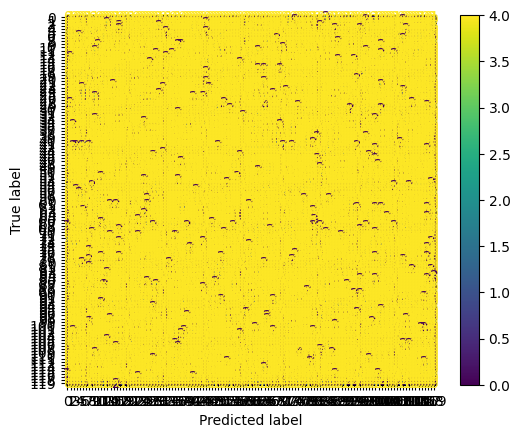

In [8]:
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()